#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

In [ ]:
Lisa Murkowski is a Chairman of Committee on Energy and Natural Resources. 

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

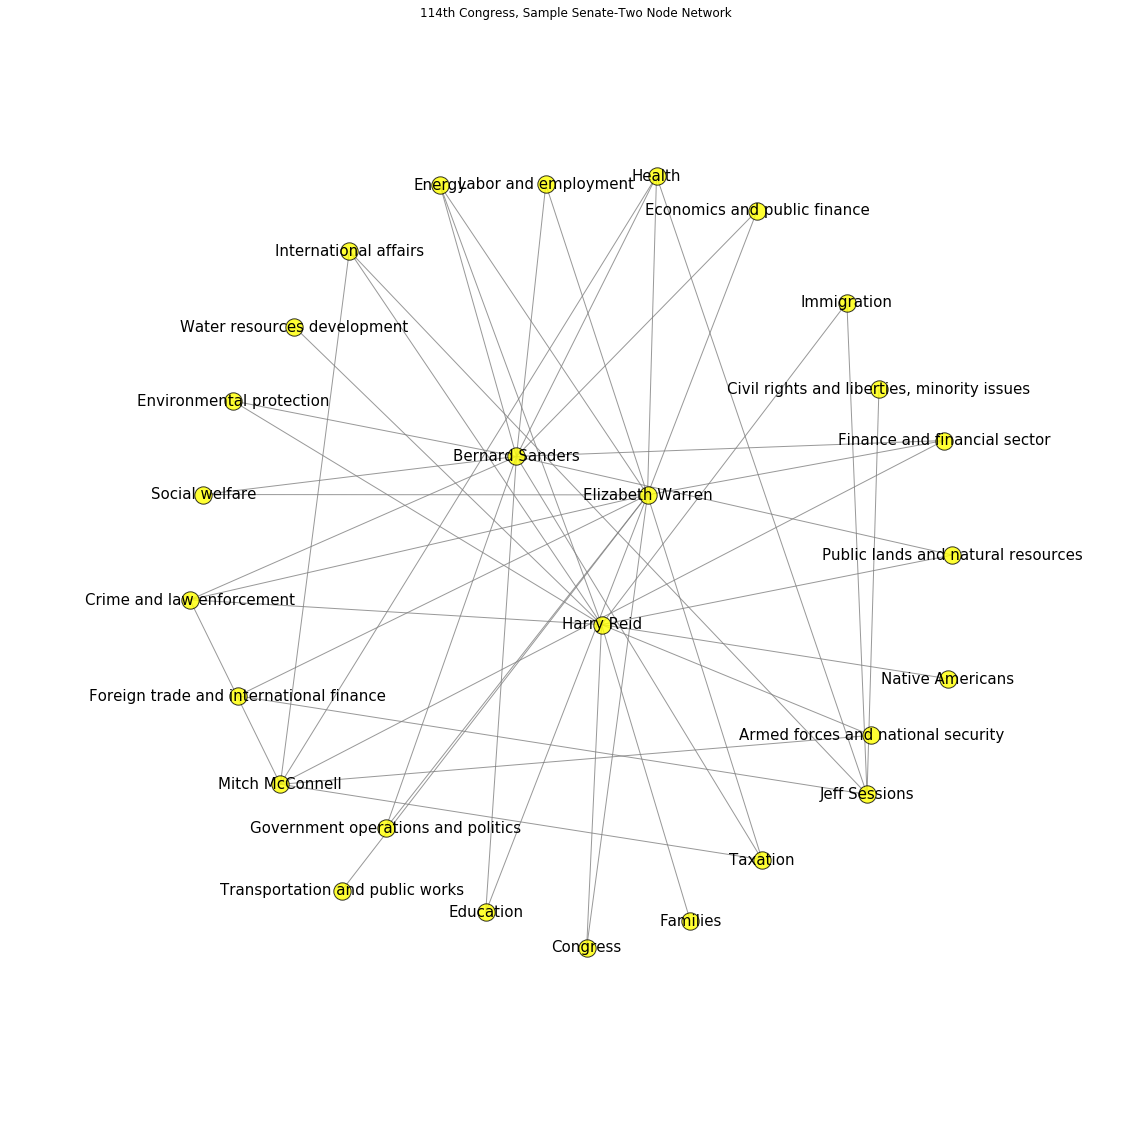

In [54]:
#Small subset data to show two-mode graph
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow', arrows=True)
plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

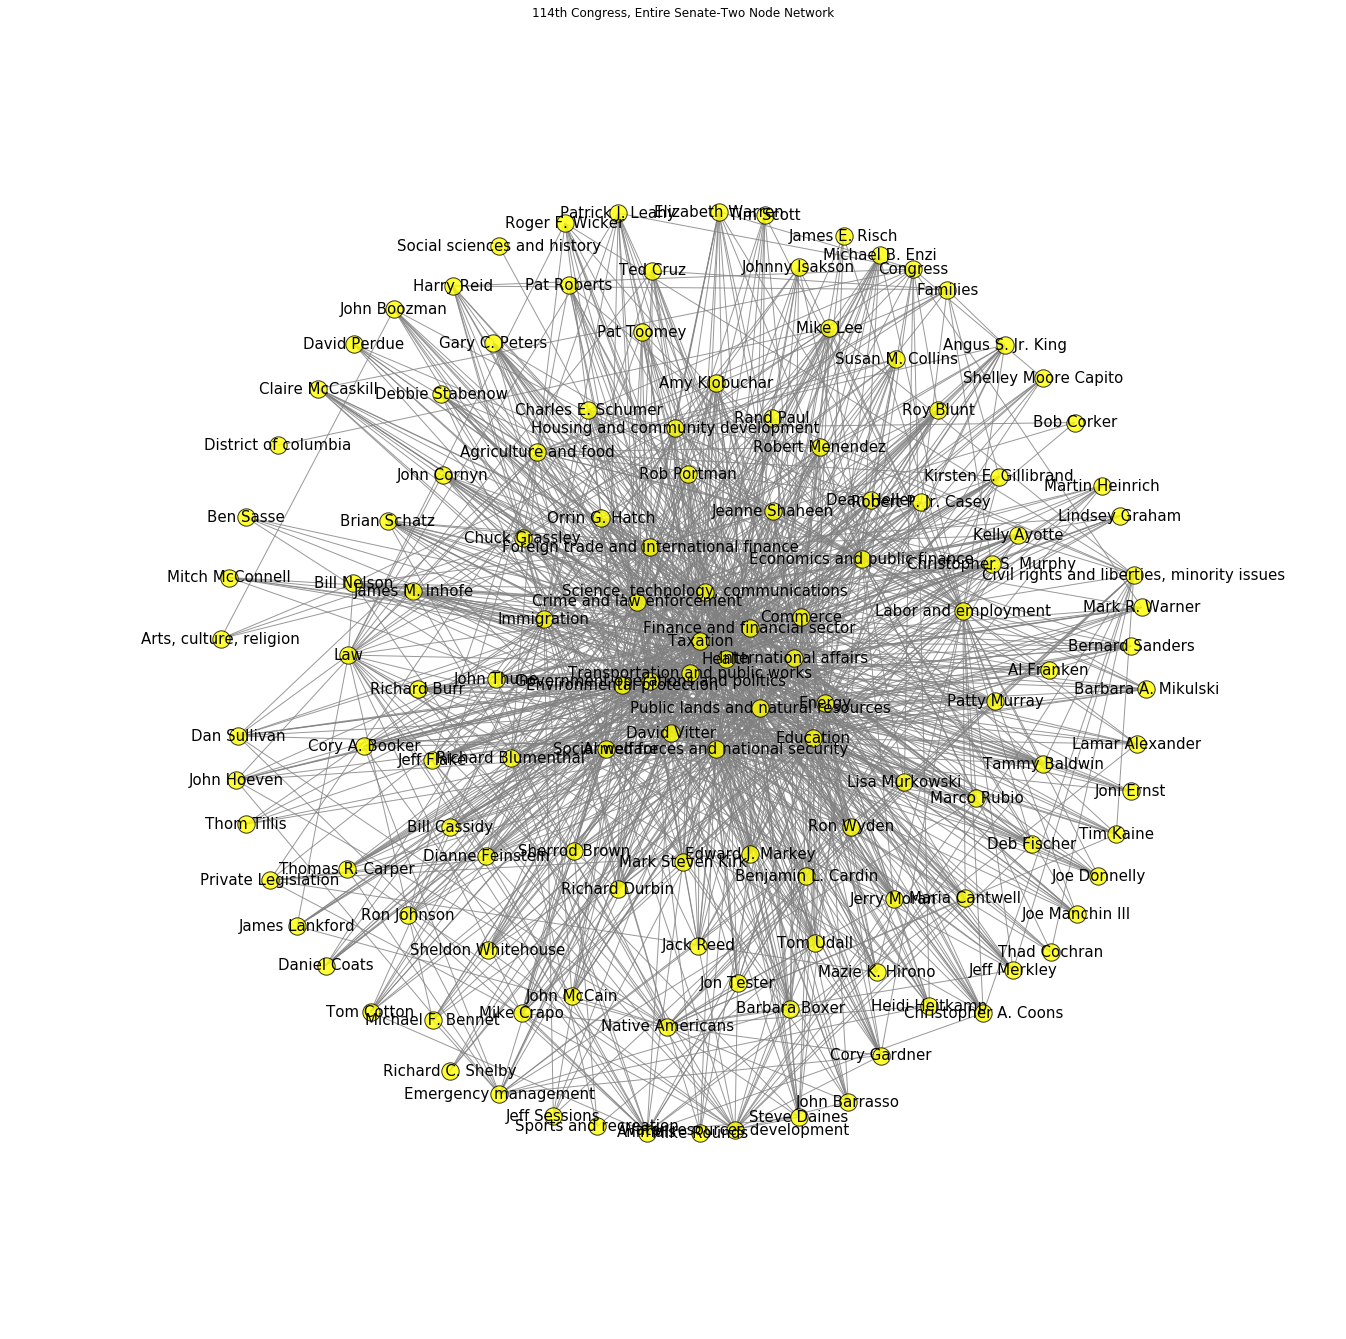

In [53]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print len(top_nodes)

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Senators'])
df

100


Senators
0            Kelly Ayotte
1            Joe Donnelly
2              Jon Tester
3          Mark R. Warner
4   Kirsten E. Gillibrand
5              Tom Cotton
6           Tammy Baldwin
7          Richard Durbin
8          Chuck Grassley
9     Robert P. Jr. Casey
10            Deb Fischer
11             Pat Toomey
12            Mike Rounds
13            Rob Portman
14         Jeanne Shaheen
15           Bill Cassidy
16      Michael F. Bennet
17       Elizabeth Warren
18            John Cornyn
19           David Vitter
20            Dean Heller
21           Thad Cochran
22            Pat Roberts
23        Bernard Sanders
24         Lindsey Graham
25            Ron Johnson
26           Cory Gardner
27        Joe Manchin III
28              Ron Wyden
29       Claire McCaskill
..                    ...
70        Lamar Alexander
71  Christopher S. Murphy
72       Mark Steven Kirk
73              Tim Kaine
74        Robert Menendez
75             Mike Crapo
76          Sherrod Brown
77           Patty Murray
78           Brian Schatz
79      Richard C. Shelby
80         Maria Cantwell
81          John Barrasso
82           Daniel Coats
83         Cory A. Booker
84         Johnny Isakson
85              Roy Blunt
86           John Boozman
87         Orrin G. Hatch
88              Tom Udall
89              Jack Reed
90        Mitch McConnell
91           Dan Sullivan
92        Roger F. Wicker
93             Al Franken
94      Angus S. Jr. King
95   Christopher A. Coons
96        James M. Inhofe
97          Jeff Sessions
98       Susan M. Collins
99     Richard Blumenthal

[100 rows x 1 columns]

In [7]:
#Total of 34 Bill Subjects
print len(bottom_nodes)

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Subjects'])
df

34


Subjects
0                         Sports and recreation
1            Armed forces and national security
2             Housing and community development
3                                        Health
4                          Emergency management
5            Government operations and politics
6                  Economics and public finance
7                                      Families
8                   Water resources development
9                                      Taxation
10                                  Immigration
11                         Labor and employment
12  Civil rights and liberties, minority issues
13                      Arts, culture, religion
14                                          Law
15                          Private Legislation
16                                     Commerce
17                    Crime and law enforcement
18                                      Animals
19                 Finance and financial sector
20      Foreign trade and international finance
21                         District of columbia
22                             Native Americans
23                  Social sciences and history
24                               Social welfare
25                                     Congress
26                                       Energy
27              Transportation and public works
28                        International affairs
29                     Environmental protection
30                         Agriculture and food
31           Public lands and natural resources
32                                    Education
33          Science, technology, communications

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(bipartite.color(B).items(), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
122                         Agriculture and food          0
94                                       Animals          0
3             Armed forces and national security          0
17                       Arts, culture, religion          0
54   Civil rights and liberties, minority issues          0
60                                      Commerce          0
85                                      Congress          0
114                    Crime and law enforcement          0
127                         District of columbia          0
83                  Economics and public finance          0
40                                     Education          0
7                           Emergency management          0
72                                        Energy          0
128                     Environmental protection          0
110                                     Families          0
100                 Finance and financial sector          0
23       Foreign trade and international finance          0
48            Government operations and politics          0
80                                        Health          0
97             Housing and community development          0
89                                   Immigration          0
126                        International affairs          0
10                          Labor and employment          0
113                                          Law          0
20                              Native Americans          0
16                           Private Legislation          0
39            Public lands and natural resources          0
74           Science, technology, communications          0
32                   Social sciences and history          0
101                               Social welfare          0
..                                           ...        ...
31                                   Pat Roberts          1
15                                    Pat Toomey          1
64                              Patrick J. Leahy          1
103                                 Patty Murray          1
59                                     Rand Paul          1
133                           Richard Blumenthal          1
88                                  Richard Burr          1
104                            Richard C. Shelby          1
11                                Richard Durbin          1
19                                   Rob Portman          1
99                               Robert Menendez          1
13                           Robert P. Jr. Casey          1
120                              Roger F. Wicker          1
35                                   Ron Johnson          1
38                                     Ron Wyden          1
46                                     Roy Blunt          1
77                            Sheldon Whitehouse          1
81                          Shelley Moore Capito          1
102                                Sherrod Brown          1
87                                  Steve Daines          1
132                             Susan M. Collins          1
9                                  Tammy Baldwin          1
47                                      Ted Cruz          1
30                                  Thad Cochran          1
45                                   Thom Tillis          1
90                              Thomas R. Carper          1
98                                     Tim Kaine          1
61                                     Tim Scott          1
6                                     Tom Cotton          1
116                                    Tom Udall          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has atleast two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(bipartite.color(B).items(), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Senator', 'Subject', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Senator', 'Subject'], ascending = True, inplace=True)
ShortPath

Senator                                      Subject  ShortestPath
3128     Al Franken           Armed forces and national security             1
3156     Al Franken                    Crime and law enforcement             1
3137     Al Franken                                    Education             1
3143     Al Franken                                       Energy             1
3134     Al Franken      Foreign trade and international finance             1
3145     Al Franken                                       Health             1
3130     Al Franken                         Labor and employment             1
3155     Al Franken                                          Law             1
3136     Al Franken           Public lands and natural resources             1
3154     Al Franken                                     Taxation             1
573   Amy Klobuchar                         Agriculture and food             1
544   Amy Klobuchar           Armed forces and national security             1
558   Amy Klobuchar                                     Commerce             1
572   Amy Klobuchar                    Crime and law enforcement             1
562   Amy Klobuchar                 Economics and public finance             1
553   Amy Klobuchar                                    Education             1
559   Amy Klobuchar                                       Energy             1
577   Amy Klobuchar                     Environmental protection             1
569   Amy Klobuchar                                     Families             1
567   Amy Klobuchar                 Finance and financial sector             1
550   Amy Klobuchar      Foreign trade and international finance             1
555   Amy Klobuchar           Government operations and politics             1
561   Amy Klobuchar                                       Health             1
564   Amy Klobuchar                                  Immigration             1
575   Amy Klobuchar                        International affairs             1
546   Amy Klobuchar                         Labor and employment             1
571   Amy Klobuchar                                          Law             1
552   Amy Klobuchar           Public lands and natural resources             1
560   Amy Klobuchar          Science, technology, communications             1
570   Amy Klobuchar                                     Taxation             1
...             ...                                          ...           ...
193      Tom Cotton                 Finance and financial sector             3
181      Tom Cotton           Government operations and politics             3
187      Tom Cotton                                       Health             3
192      Tom Cotton            Housing and community development             3
172      Tom Cotton                         Labor and employment             3
197      Tom Cotton                                          Law             3
175      Tom Cotton                             Native Americans             3
173      Tom Cotton                          Private Legislation             3
178      Tom Cotton           Public lands and natural resources             3
186      Tom Cotton          Science, technology, communications             3
177      Tom Cotton                  Social sciences and history             3
180      Tom Cotton                        Sports and recreation             3
200      Tom Cotton              Transportation and public works             3
182      Tom Cotton                  Water resources development             3
2979      Tom Udall                                      Animals             3
2962      Tom Udall                      Arts, culture, religion             3
2971      Tom Udall  Civil rights and liberties, minority issues             3
2986      Tom Udall                    Crime and law enforcement             3
2990      Tom Udall                         District of columb

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
df = pd.DataFrame(close.items(), columns=['Node', 'Closeness'])
df.sort_values(['Closeness', 'Node'], ascending = False, inplace=True)
df

Node  Closeness
37                                        Health   0.692708
132                                     Taxation   0.651961
79            Public lands and natural resources   0.604545
46            Government operations and politics   0.599099
3             Armed forces and national security   0.588496
125              Transportation and public works   0.545082
114                    Crime and law enforcement   0.545082
38                                     Education   0.527778
5                                   David Vitter   0.523622
126                        International affairs   0.519531
98                  Finance and financial sector   0.515504
128                     Environmental protection   0.515504
77                                 Amy Klobuchar   0.515504
91                                    Jeff Flake   0.511538
115                               Orrin G. Hatch   0.507634
19                                Jeanne Shaheen   0.507634
116                                    Tom Udall   0.503788
36                                     Ron Wyden   0.503788
18                               Robert Menendez   0.503788
97                                   Rob Portman   0.503788
10                                Richard Durbin   0.503788
133                           Richard Blumenthal   0.503788
61                                      Mike Lee   0.503788
95                              Mark Steven Kirk   0.503788
55                            Charles E. Schumer   0.503788
23                                    Mike Crapo   0.500000
64                                   Marco Rubio   0.500000
130                              James M. Inhofe   0.500000
16                              Dianne Feinstein   0.500000
51                                   Bill Nelson   0.500000
..                                           ...        ...
28                                  Thad Cochran   0.458621
80                          Shelley Moore Capito   0.458621
118                              Mitch McConnell   0.458621
92                               Lamar Alexander   0.458621
131                                Jeff Sessions   0.449324
54                                     Ben Sasse   0.449324
104                            Richard C. Shelby   0.446309
17                                   Mike Rounds   0.446309
82                  Economics and public finance   0.446309
99                                Social welfare   0.443333
88                                   Immigration   0.443333
43                                   Thom Tillis   0.437500
81                                James E. Risch   0.437500
122      Foreign trade and international finance   0.437500
103                         Agriculture and food   0.423567
21                              Native Americans   0.420886
113                                          Law   0.418239
44             Housing and community development   0.413043
124                  Water resources development   0.407975
93                                       Animals   0.398204
84                                      Congress   0.393491
52   Civil rights and liberties, minority issues   0.391176
7                           Emergency management   0.388889
48                                    Bob Corker   0.384393
110                                     Families   0.375706
15                           Private Legislation   0.371508
42                         Sports and recreation   0.355615
53                       Arts, culture, religion   0.355615
30                   Social sciences and history   0.335859
127                         District of columbia   0.335859

[134 rows x 2 columns]

In [14]:
#Betweenness centrality between Senetors and bill subjects
between = nx.betweenness_centrality(B)
df = pd.DataFrame(between.items(), columns=['Node', 'Betweenness'])
df.sort_values(['Betweenness', 'Node'], ascending = False, inplace=True)
df

Node  Betweenness
37                                    Health     0.101990
132                                 Taxation     0.081904
79        Public lands and natural resources     0.064795
3         Armed forces and national security     0.064645
46        Government operations and politics     0.063533
126                    International affairs     0.046628
114                Crime and law enforcement     0.045923
125          Transportation and public works     0.042655
98              Finance and financial sector     0.036473
38                                 Education     0.035685
128                 Environmental protection     0.033388
70                                    Energy     0.028387
55                        Charles E. Schumer     0.021357
9                       Labor and employment     0.020688
58                                  Commerce     0.020632
61                                  Mike Lee     0.019391
73       Science, technology, communications     0.018509
88                               Immigration     0.015822
82              Economics and public finance     0.015759
122  Foreign trade and international finance     0.015152
99                            Social welfare     0.014690
116                                Tom Udall     0.009767
133                       Richard Blumenthal     0.009606
5                               David Vitter     0.008982
21                          Native Americans     0.008903
130                          James M. Inhofe     0.008501
103                     Agriculture and food     0.008114
51                               Bill Nelson     0.007933
44         Housing and community development     0.007747
11                            Chuck Grassley     0.007251
..                                       ...          ...
14                                Pat Toomey     0.001200
121                               Al Franken     0.001091
1                               Joe Donnelly     0.001042
110                                 Families     0.000968
22                         Michael F. Bennet     0.000955
65                           Martin Heinrich     0.000904
29                               Pat Roberts     0.000889
35                           Joe Manchin III     0.000886
92                           Lamar Alexander     0.000788
107                             Daniel Coats     0.000755
80                      Shelley Moore Capito     0.000670
71                            James Lankford     0.000648
32                            Lindsey Graham     0.000598
28                              Thad Cochran     0.000557
68                              David Perdue     0.000548
131                            Jeff Sessions     0.000474
56                                Joni Ernst     0.000452
59                                 Tim Scott     0.000432
15                       Private Legislation     0.000422
17                               Mike Rounds     0.000284
43                               Thom Tillis     0.000262
118                          Mitch McConnell     0.000255
81                            James E. Risch     0.000176
104                        Richard C. Shelby     0.000151
54                                 Ben Sasse     0.000134
53                   Arts, culture, religion     0.000126
48                                Bob Corker     0.000115
42                     Sports and recreation     0.000054
30               Social sciences and history     0.000000
127                     District of columbia     0.000000

[134 rows x 2 columns]

In [15]:
#Degrees centrality between Senetors and bill subjects
degree = nx.degree_centrality(B)
df = pd.DataFrame(degree.items(), columns=['Node', 'Degrees'])
df.sort_values(['Degrees', 'Node'], ascending = False, inplace=True)
df

Node   Degrees
37                                    Health  0.661654
132                                 Taxation  0.616541
79        Public lands and natural resources  0.548872
46        Government operations and politics  0.541353
3         Armed forces and national security  0.533835
125          Transportation and public works  0.458647
114                Crime and law enforcement  0.458647
38                                 Education  0.436090
126                    International affairs  0.413534
98              Finance and financial sector  0.413534
128                 Environmental protection  0.406015
70                                    Energy  0.383459
58                                  Commerce  0.338346
9                       Labor and employment  0.330827
73       Science, technology, communications  0.315789
82              Economics and public finance  0.270677
99                            Social welfare  0.255639
88                               Immigration  0.255639
122  Foreign trade and international finance  0.240602
21                          Native Americans  0.203008
103                     Agriculture and food  0.203008
113                                      Law  0.195489
5                               David Vitter  0.172932
124              Water resources development  0.165414
44         Housing and community development  0.165414
77                             Amy Klobuchar  0.157895
91                                Jeff Flake  0.150376
115                           Orrin G. Hatch  0.142857
19                            Jeanne Shaheen  0.142857
93                                   Animals  0.142857
..                                       ...       ...
35                           Joe Manchin III  0.075188
1                               Joe Donnelly  0.075188
41                       Barbara A. Mikulski  0.075188
121                               Al Franken  0.075188
6                                 Tom Cotton  0.067669
96                                 Tim Kaine  0.067669
65                           Martin Heinrich  0.067669
59                                 Tim Scott  0.060150
22                         Michael F. Bennet  0.060150
32                            Lindsey Graham  0.060150
92                           Lamar Alexander  0.060150
107                             Daniel Coats  0.060150
80                      Shelley Moore Capito  0.052632
15                       Private Legislation  0.052632
56                                Joni Ernst  0.052632
71                            James Lankford  0.052632
68                              David Perdue  0.052632
28                              Thad Cochran  0.045113
118                          Mitch McConnell  0.045113
43                               Thom Tillis  0.037594
17                               Mike Rounds  0.037594
131                            Jeff Sessions  0.037594
81                            James E. Risch  0.037594
104                        Richard C. Shelby  0.030075
54                                 Ben Sasse  0.030075
53                   Arts, culture, religion  0.030075
42                     Sports and recreation  0.022556
48                                Bob Corker  0.022556
30               Social sciences and history  0.007519
127                     District of columbia  0.007519

[134 rows x 2 columns]

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

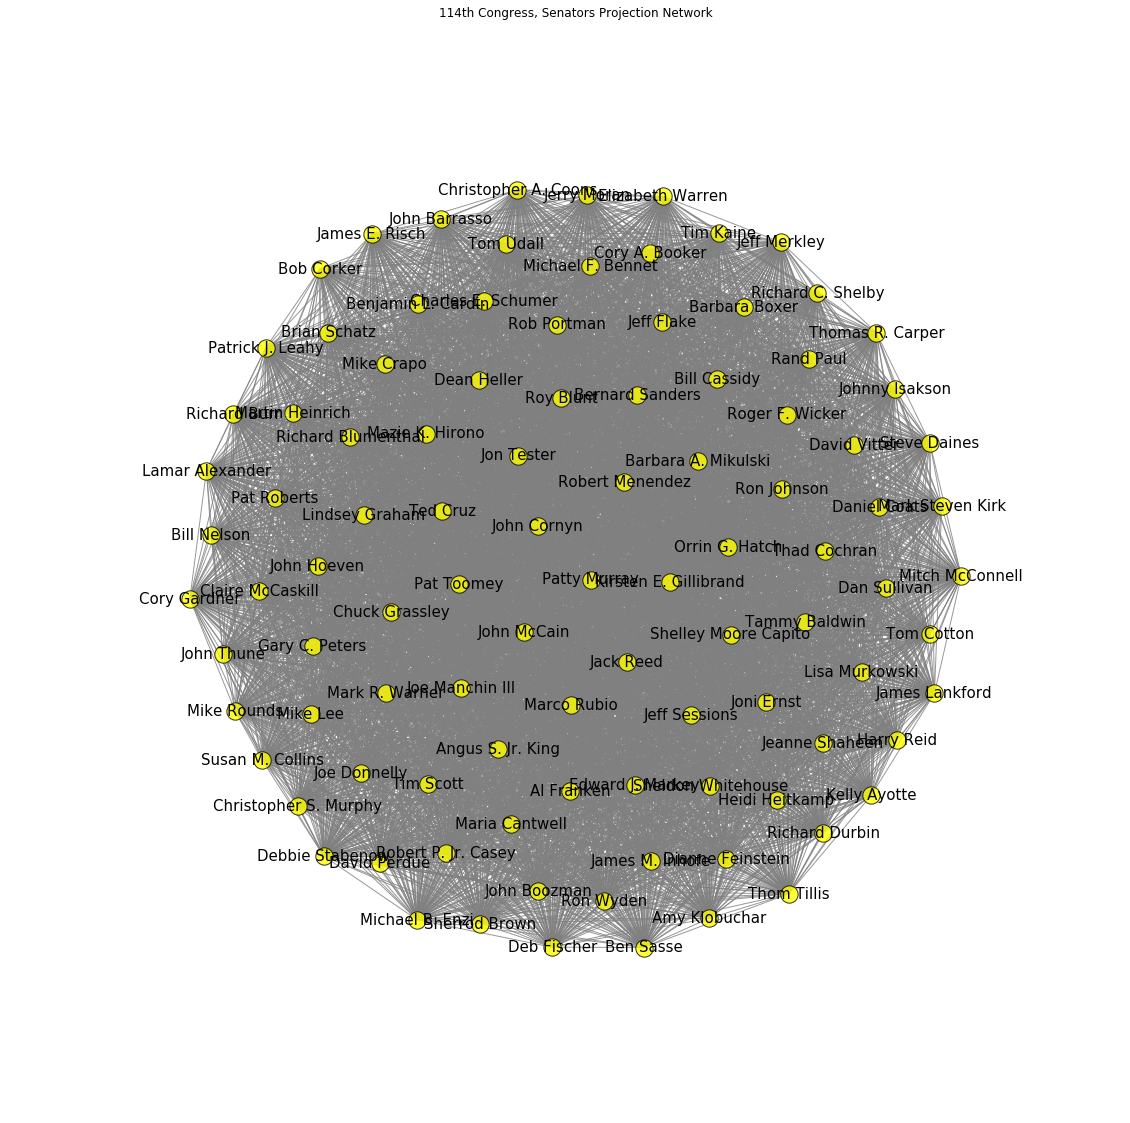

In [16]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

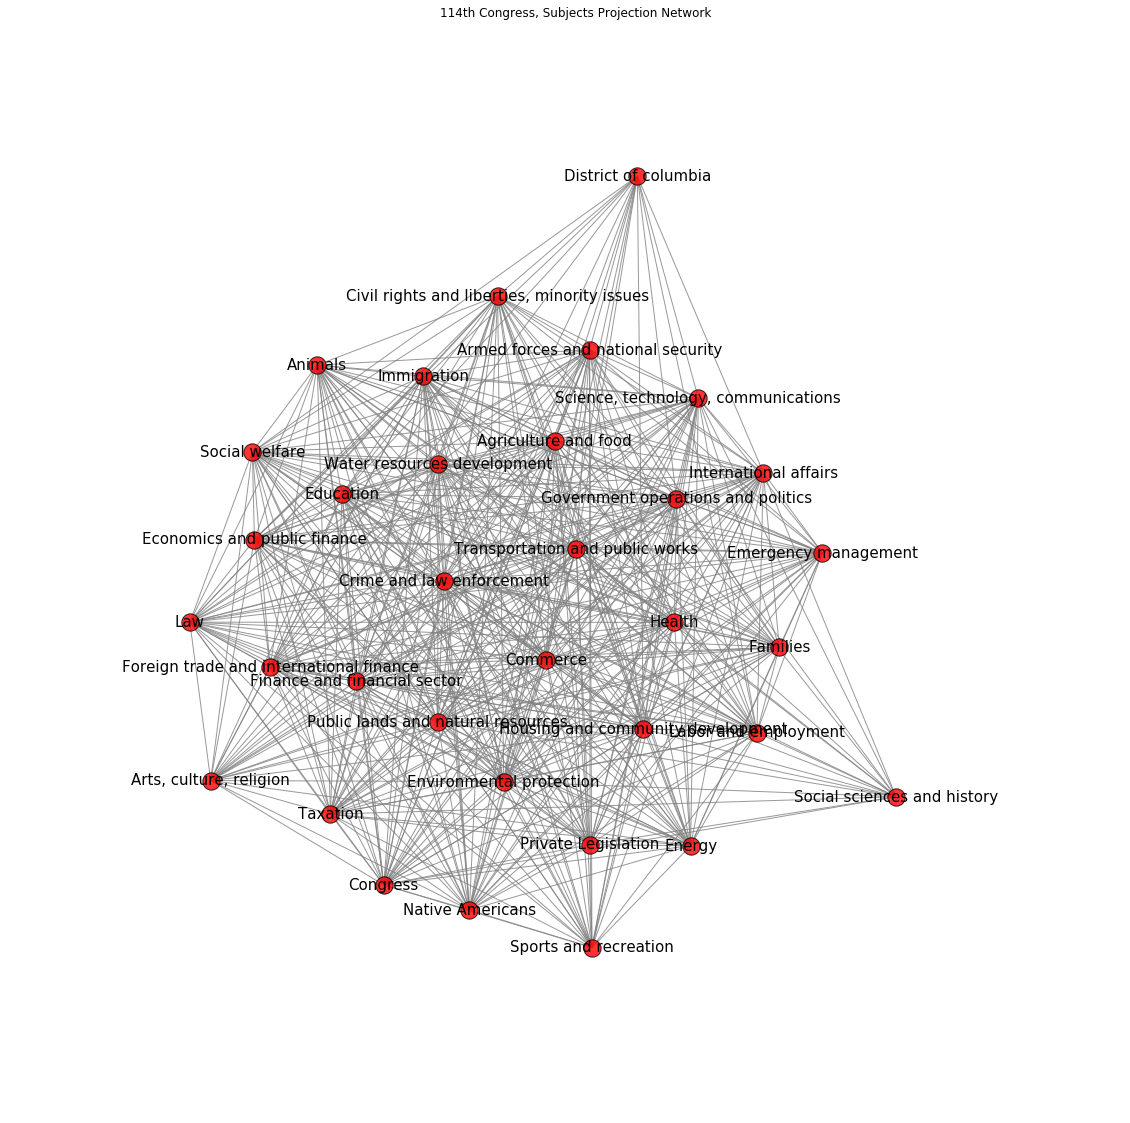

In [17]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'red')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [18]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.372058823529
0.372058823529


###Clustering

Following data show, there is no clustering when a complete network is analyzed. In this case, the network is analyzed as a one-mode network. This type of clustering metrics does not provide a complete picture.

In [19]:
c = nx.clustering(B)
df = pd.DataFrame(c.items(), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
124                  Water resources development         0.0
125              Transportation and public works         0.0
116                                    Tom Udall         0.0
6                                     Tom Cotton         0.0
59                                     Tim Scott         0.0
96                                     Tim Kaine         0.0
89                              Thomas R. Carper         0.0
43                                   Thom Tillis         0.0
28                                  Thad Cochran         0.0
45                                      Ted Cruz         0.0
132                                     Taxation         0.0
8                                  Tammy Baldwin         0.0
72                              Susan M. Collins         0.0
86                                  Steve Daines         0.0
42                         Sports and recreation         0.0
99                                Social welfare         0.0
30                   Social sciences and history         0.0
100                                Sherrod Brown         0.0
80                          Shelley Moore Capito         0.0
76                            Sheldon Whitehouse         0.0
73           Science, technology, communications         0.0
111                                    Roy Blunt         0.0
36                                     Ron Wyden         0.0
33                                   Ron Johnson         0.0
120                              Roger F. Wicker         0.0
12                           Robert P. Jr. Casey         0.0
18                               Robert Menendez         0.0
97                                   Rob Portman         0.0
10                                Richard Durbin         0.0
104                            Richard C. Shelby         0.0
..                                           ...         ...
68                                  David Perdue         0.0
107                                 Daniel Coats         0.0
119                                 Dan Sullivan         0.0
114                    Crime and law enforcement         0.0
34                                  Cory Gardner         0.0
108                               Cory A. Booker         0.0
84                                      Congress         0.0
58                                      Commerce         0.0
39                              Claire McCaskill         0.0
52   Civil rights and liberties, minority issues         0.0
11                                Chuck Grassley         0.0
94                         Christopher S. Murphy         0.0
129                         Christopher A. Coons         0.0
55                            Charles E. Schumer         0.0
102                                 Brian Schatz         0.0
48                                    Bob Corker         0.0
51                                   Bill Nelson         0.0
20                                  Bill Cassidy         0.0
31                               Bernard Sanders         0.0
63                            Benjamin L. Cardin         0.0
54                                     Ben Sasse         0.0
66                                 Barbara Boxer         0.0
41                           Barbara A. Mikulski         0.0
53                       Arts, culture, religion         0.0
3             Armed forces and national security         0.0
93                                       Animals         0.0
123                            Angus S. Jr. King         0.0
77                                 Amy Klobuchar         0.0
121                                   Al Franken         0.0
103                         Agriculture and food         0.0

[134 rows x 2 columns]

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [20]:
c = bipartite.clustering(B)
df = pd.DataFrame(c.items(), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
67                                Gary C. Peters    0.467979
50                              Edward J. Markey    0.466050
77                                 Amy Klobuchar    0.465132
97                                   Rob Portman    0.458394
95                              Mark Steven Kirk    0.457735
101                                 Patty Murray    0.449602
8                                  Tammy Baldwin    0.443799
102                                 Brian Schatz    0.443223
115                               Orrin G. Hatch    0.438549
111                                    Roy Blunt    0.433688
66                                 Barbara Boxer    0.429799
27                                   Dean Heller    0.428701
36                                     Ron Wyden    0.428436
0                                   Kelly Ayotte    0.427624
10                                Richard Durbin    0.424544
26                         Kirsten E. Gillibrand    0.424226
25                                   John Cornyn    0.423339
5                                   David Vitter    0.422189
19                                Jeanne Shaheen    0.421120
47                               Michael B. Enzi    0.416889
20                                  Bill Cassidy    0.415656
34                                  Cory Gardner    0.414451
40                                   Jerry Moran    0.406920
108                               Cory A. Booker    0.406413
60                                    John Thune    0.406024
31                               Bernard Sanders    0.404171
64                                   Marco Rubio    0.402996
94                         Christopher S. Murphy    0.402861
76                            Sheldon Whitehouse    0.398786
91                                    Jeff Flake    0.398304
..                                           ...         ...
71                                James Lankford    0.248444
49                                    Harry Reid    0.244810
68                                  David Perdue    0.236183
28                                  Thad Cochran    0.228641
82                  Economics and public finance    0.218295
99                                Social welfare    0.214168
88                                   Immigration    0.211763
113                                          Law    0.207037
103                         Agriculture and food    0.205080
81                                James E. Risch    0.201195
122      Foreign trade and international finance    0.200920
17                                   Mike Rounds    0.189306
54                                     Ben Sasse    0.185288
21                              Native Americans    0.174577
124                  Water resources development    0.169541
44             Housing and community development    0.167055
43                                   Thom Tillis    0.165161
104                            Richard C. Shelby    0.164930
131                                Jeff Sessions    0.153204
93                                       Animals    0.148732
7                           Emergency management    0.145375
52   Civil rights and liberties, minority issues    0.126924
84                                      Congress    0.118515
110                                     Families    0.118401
48                                    Bob Corker    0.101726
15                           Private Legislation    0.082698
53                       Arts, culture, religion    0.053245
42                         Sports and recreation    0.042717
30                   Social sciences and history    0.032616
127                         District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [21]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                  node2  \
0            Kelly Ayotte         Mark R. Warner   
1            Kelly Ayotte         Mark R. Warner   
2            Kelly Ayotte         Mark R. Warner   
3            Kelly Ayotte         Richard Durbin   
4            Kelly Ayotte         Richard Durbin   
5            Kelly Ayotte    Robert P. Jr. Casey   
6            Kelly Ayotte    Robert P. Jr. Casey   
7            Kelly Ayotte             Pat Toomey   
8            Kelly Ayotte            Rob Portman   
9            Kelly Ayotte            Rob Portman   
10           Kelly Ayotte            Rob Portman   
11           Kelly Ayotte      Michael F. Bennet   
12           Kelly Ayotte      Michael F. Bennet   
13           Kelly Ayotte  Kirsten E. Gillibrand   
14           Kelly Ayotte  Kirsten E. Gillibrand   
15           Kelly Ayotte  Kirsten E. Gillibrand   
16           Kelly Ayotte  Kirsten E. Gillibrand   
17           Kelly Ayotte           Thad Cochran   
18           Kelly Ayotte            Pat Roberts   
19           Kelly Ayotte            Pat Roberts   
20           Kelly Ayotte            Pat Roberts   
21           Kelly Ayotte         Lindsey Graham   
22           Kelly Ayotte         Lindsey Graham   
23           Kelly Ayotte            Ron Johnson   
24           Kelly Ayotte              Ron Wyden   
25           Kelly Ayotte              Ron Wyden   
26           Kelly Ayotte              Ron Wyden   
27           Kelly Ayotte            Thom Tillis   
28           Kelly Ayotte        Michael B. Enzi   
29           Kelly Ayotte        Michael B. Enzi   
...                   ...                    ...   
12902  Richard Blumenthal              Ron Wyden   
12903  Richard Blumenthal              Ron Wyden   
12904  Richard Blumenthal              Ron Wyden   
12905  Richard Blumenthal              Ron Wyden   
12906  Richard Blumenthal            Thom Tillis   
12907  Richard Blumenthal          Tammy Baldwin   
12908  Richard Blumenthal          Tammy Baldwin   
12909  Richard Blumenthal     Sheldon Whitehouse   
12910  Richard Blumenthal     Sheldon Whitehouse   
12911  Richard Blumenthal     Sheldon Whitehouse   
12912  Richard Blumenthal   Shelley Moore Capito   
12913  Richard Blumenthal           Steve Daines   
12914  Richard Blumenthal           Richard Burr   
12915  Richard Blumenthal           Richard Burr   
12916  Richard Blumenthal       Thomas R. Carper   
12917  Richard Blumenthal        Robert Menendez   
12918  Richard Blumenthal        Robert Menendez   
12919  Richard Blumenthal          Sherrod Brown   
12920  Richard Blumenthal          Sherrod Brown   
12921  Richard Blumenthal          Sherrod Brown   
12922  Richard Blumenthal          Sherrod Brown   
12923  Richard Blumenthal      Richard C. Shelby   
12924  Richard Blumenthal              Roy Blunt   
12925  Richard Blumenthal              Roy Blunt   
12926  Richard Blumenthal              Roy Blunt   
12927  Richard Blumenthal              Roy Blunt   
12928  Richard Blumenthal              Tom Udall   
12929  Richard Blumenthal        Roger F. Wicker   
12930  Richard Blumenthal        Roger F. Wicker   
12931  Richard Blumenthal       Susan M. Collins   

                                     node3  
0                                 Taxation  
1          Transportation and public works  
2       Public lands and natural resources  
3                                 Taxation  
4      Science, technology, communications  
5                                 Taxation  
6          Transportation and public works  
7                                 Taxation  
8                                 Taxation  
9          Transportation and public works  
10     Science, technology, communications  
11                                Taxation  
12      Public lands and natural resources  
13                                Taxation  
14         Transportation and public works  
15                    Labor and employment  
16      Public lands and natur

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [23]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(c.items(), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
37                                    Health       88
132                                 Taxation       82
79        Public lands and natural resources       73
46        Government operations and politics       72
3         Armed forces and national security       71
125          Transportation and public works       61
114                Crime and law enforcement       61
38                                 Education       58
126                    International affairs       55
98              Finance and financial sector       55
128                 Environmental protection       54
70                                    Energy       51
58                                  Commerce       45
9                       Labor and employment       44
73       Science, technology, communications       42
82              Economics and public finance       36
99                            Social welfare       34
88                               Immigration       34
122  Foreign trade and international finance       32
21                          Native Americans       27
103                     Agriculture and food       27
113                                      Law       26
5                               David Vitter       23
124              Water resources development       22
44         Housing and community development       22
77                             Amy Klobuchar       21
91                                Jeff Flake       20
115                           Orrin G. Hatch       19
19                            Jeanne Shaheen       19
93                                   Animals       19
..                                       ...      ...
35                           Joe Manchin III       10
1                               Joe Donnelly       10
41                       Barbara A. Mikulski       10
121                               Al Franken       10
6                                 Tom Cotton        9
96                                 Tim Kaine        9
65                           Martin Heinrich        9
59                                 Tim Scott        8
22                         Michael F. Bennet        8
32                            Lindsey Graham        8
92                           Lamar Alexander        8
107                             Daniel Coats        8
80                      Shelley Moore Capito        7
15                       Private Legislation        7
56                                Joni Ernst        7
71                            James Lankford        7
68                              David Perdue        7
28                              Thad Cochran        6
118                          Mitch McConnell        6
43                               Thom Tillis        5
17                               Mike Rounds        5
131                            Jeff Sessions        5
81                            James E. Risch        5
104                        Richard C. Shelby        4
54                                 Ben Sasse        4
53                   Arts, culture, religion        4
42                     Sports and recreation        3
48                                Bob Corker        3
30               Social sciences and history        1
127                     District of columbia        1

[134 rows x 2 columns]

On a projected graph, bill subject *Transportation and public works* stand out. That means this subject is more popular among Senators.

In [24]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(c.items(), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
27              Transportation and public works        6
33          Science, technology, communications        6
31           Public lands and natural resources        6
28                        International affairs        6
2             Housing and community development        6
5            Government operations and politics        6
29                     Environmental protection        6
17                    Crime and law enforcement        6
16                                     Commerce        6
9                                      Taxation        5
24                               Social welfare        5
11                         Labor and employment        5
10                                  Immigration        5
3                                        Health        5
20      Foreign trade and international finance        5
19                 Finance and financial sector        5
32                                    Education        5
25                                     Congress        5
1            Armed forces and national security        5
30                         Agriculture and food        5
8                   Water resources development        4
22                             Native Americans        4
14                                          Law        4
26                                       Energy        4
6                  Economics and public finance        4
15                          Private Legislation        3
12  Civil rights and liberties, minority issues        3
18                                      Animals        3
7                                      Families        2
4                          Emergency management        2
0                         Sports and recreation        1
23                  Social sciences and history        1
21                         District of columbia        1
13                      Arts, culture, religion        1

On a projected graph, following table, shows subgroups among bill subjects. That means these subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [25]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1  \
0                   Sports and recreation   
1                   Sports and recreation   
2                   Sports and recreation   
3      Armed forces and national security   
4      Armed forces and national security   
5      Armed forces and national security   
6      Armed forces and national security   
7      Armed forces and national security   
8      Armed forces and national security   
9      Armed forces and national security   
10     Armed forces and national security   
11     Armed forces and national security   
12     Armed forces and national security   
13     Armed forces and national security   
14     Armed forces and national security   
15     Armed forces and national security   
16     Armed forces and national security   
17     Armed forces and national security   
18     Armed forces and national security   
19     Armed forces and national security   
20     Armed forces and national security   
21     Armed forces and national security   
22     Armed forces and national security   
23     Armed forces and national security   
24     Armed forces and national security   
25     Armed forces and national security   
26     Armed forces and national security   
27     Armed forces and national security   
28     Armed forces and national security   
29     Armed forces and national security   
...                                   ...   
5115                            Education   
5116                            Education   
5117                            Education   
5118                            Education   
5119                            Education   
5120                            Education   
5121                            Education   
5122                            Education   
5123                            Education   
5124                            Education   
5125                            Education   
5126                            Education   
5127                            Education   
5128                            Education   
5129                            Education   
5130                            Education   
5131                            Education   
5132                            Education   
5133  Science, technology, communications   
5134  Science, technology, communications   
5135  Science, technology, communications   
5136  Science, technology, communications   
5137  Science, technology, communications   
5138  Science, technology, communications   
5139  Science, technology, communications   
5140  Science, technology, communications   
5141  Science, technology, communications   
5142  Science, technology, communications   
5143  Science, technology, communications   
5144  Science, technology, communications   

                                    node2  \
0                                Taxation   
1                                Taxation   
2         Transportation and public works   
3                   Sports and recreation   
4                   Sports and recreation   
5                   Sports and recreation   
6       Housing and community development   
7       Housing and community development   
8       Housing and community development   
9       Housing and community development   
10      Housing and community development   
11      Housing and community development   
12      Housing and community development   
13      Housing and community development   
14      Housing and community development   
15      Housing and community development   
16      Housing and community development   
17      Housing and community development   
18      Housing and community development   
19                                 Health   
20                                 Health   
21                                 Health   
22                                 Health   
23                                 Health   
24                                 Health   
25                                 Health   
26                            

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [26]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [27]:
print '%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands')
for i in islands:
    print '%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])])

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [7, 6, 8]    
16                        8                                             [3, 2, 3]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


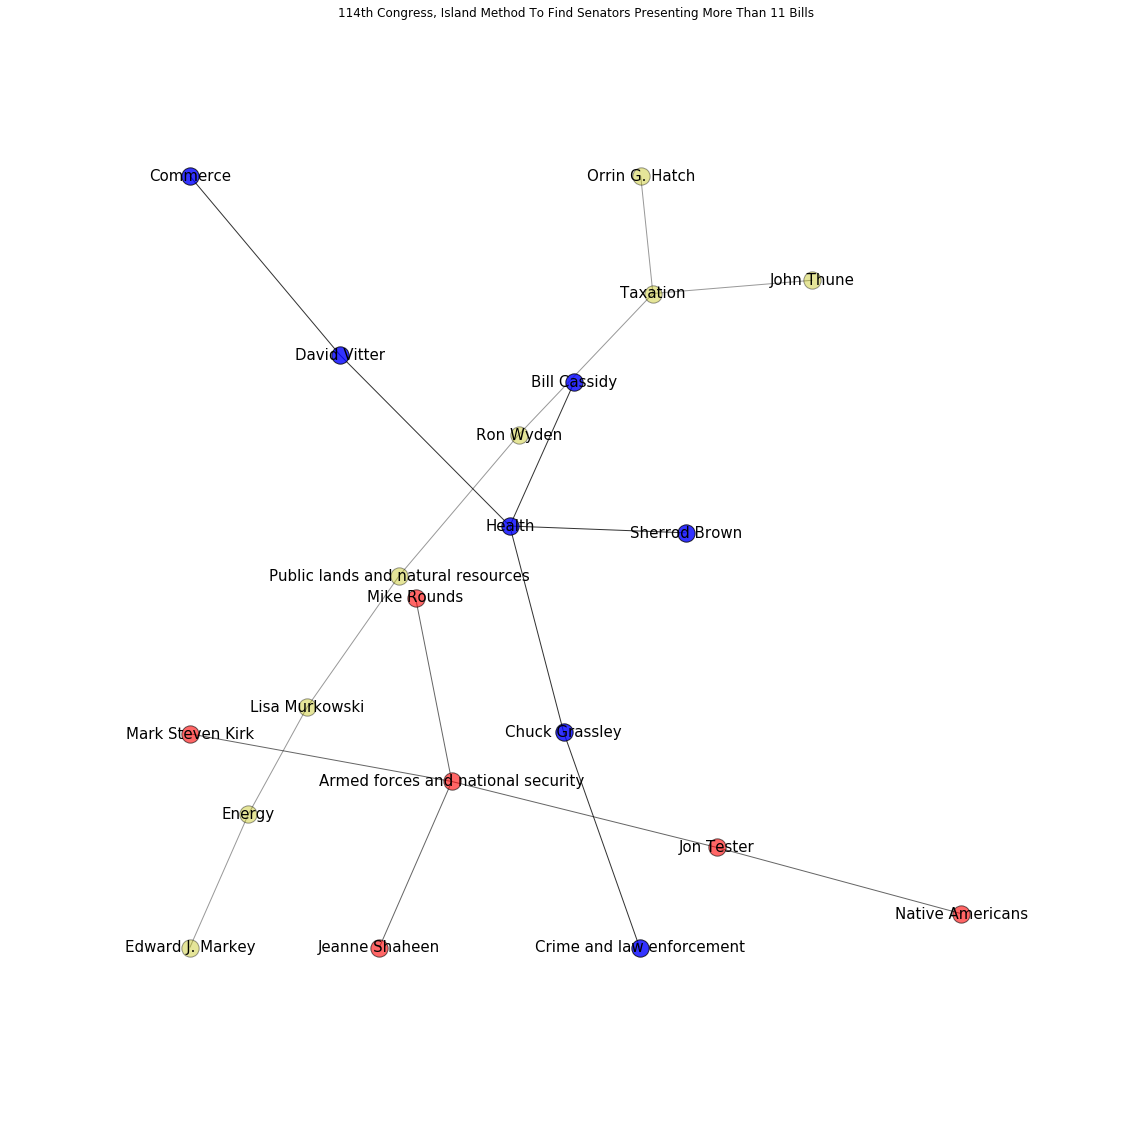

In [42]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


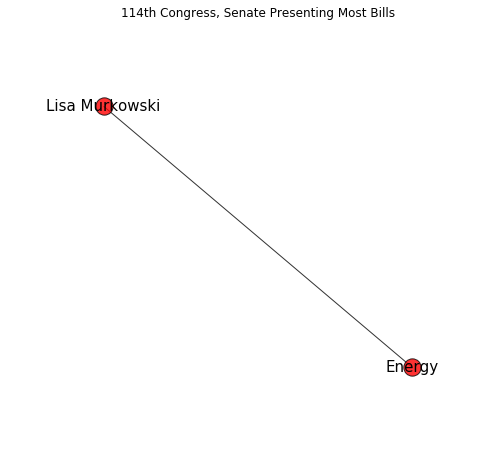

In [29]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()